In [171]:
import numpy as np
import pandas as pd
from shutil import copyfile
from matplotlib import gridspec
from astropy.io import fits
from astropy import wcs
import collections
from IPython.display import Image

from astropy.table import Table
from spec_tools import Source_present, Get_Sensitivity,Mag
from spec_exam import Gen_beam_fits, Gen_DB_and_beams
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from glob import glob
import seaborn as sea
import os
from grizli import model as griz_model

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

# Get list of all objects

In [10]:
cleardir = hpath +'Data/CLEAR' # sets path to be $HOME/Data/CLEAR
# sets path to be $HOME/Data/CLEAR
# cleardir should include (available from the website): 
#    RELEASE_v1.0.0/
#    RELEASE_v1.0.0/CATALOGS/
# available from:  https://archive.stsci.edu/pub/clear_team/

threeddir = hpath + 'Data/3D-HST/CATALOGS'

# should include 
#    goodsn_3dhst.v4.1.cats/
#.      Catalog/                
#.      Eazy/ 
#       Fast/
#.      RF_colors/
#    goodss_3dhst.v4.1.cats/
#.      Catalog/                
#.      Eazy/ 
#       Fast/
#.      RF_colors/
# available from:  https://3dhst.research.yale.edu/Data.php


catdir = os.path.join(cleardir,'CATALOGS') 
# sets path for $HOME/Data/CLEAR/CATALOGS
# should include all files from CATALOGS/ directory at: 
#     https://archive.stsci.edu/pub/clear_team/CATALOGS/
#    

linedir = os.path.join(cleardir,'RELEASE_v1.0.0/CATALOGS')
# should include all files from RELEASE_v1.0.0/CATALOGS/ directory at:
#.    https://archive.stsci.edu/pub/clear_team/RELEASE_v1.0.0/CATALOGS/

combineddir = os.path.join(cleardir,'RELEASE_v1.0.0/COMBINED')
# shoudl include all files from https://archive.stsci.edu/pub/clear_team/RELEASE_v1.0.0/
# download the tar.gz files and untar them - I sent a .sh script that has suggested ways to download everything.

In [11]:
### Check that all the directories we just set up do exist:

for d in [cleardir, catdir, linedir, threeddir,combineddir] :
    if os.path.exists(d) : print ("EXISTS: %s" % d)
    else : print("DOES NOT EXIST: %s" %  d)


EXISTS: /Users/vestrada/Data/CLEAR
EXISTS: /Users/vestrada/Data/CLEAR/CATALOGS
EXISTS: /Users/vestrada/Data/CLEAR/RELEASE_v1.0.0/CATALOGS
EXISTS: /Users/vestrada/Data/3D-HST/CATALOGS
EXISTS: /Users/vestrada/Data/CLEAR/RELEASE_v1.0.0/COMBINED


In [12]:
gndfile = os.path.join(catdir,'goodsn_3dhst.v4.3.cat')
gndzoutfile = os.path.join(catdir,'goodsn_v4.3.zout')
gndlinefile = os.path.join(linedir,'GN_CLEAR.linefit.concat.v1.0.0.fits')
gndzfitfile = os.path.join(linedir,'GN_CLEAR.zfit.concat.v1.0.0.fits')
gndfoutfile = os.path.join(catdir,'goodsn_v4.3.fout')

# all need to exist:
for file in [gndfile, gndzoutfile, gndlinefile, gndzfitfile,gndfoutfile] : 
    if os.path.exists(file) : print ("EXISTS: %s" % file)
    else: print("DOES NOT EXIST: %s" %  d)

EXISTS: /Users/vestrada/Data/CLEAR/CATALOGS/goodsn_3dhst.v4.3.cat
EXISTS: /Users/vestrada/Data/CLEAR/CATALOGS/goodsn_v4.3.zout
EXISTS: /Users/vestrada/Data/CLEAR/RELEASE_v1.0.0/CATALOGS/GN_CLEAR.linefit.concat.v1.0.0.fits
EXISTS: /Users/vestrada/Data/CLEAR/RELEASE_v1.0.0/CATALOGS/GN_CLEAR.zfit.concat.v1.0.0.fits
EXISTS: /Users/vestrada/Data/CLEAR/CATALOGS/goodsn_v4.3.fout


In [13]:
gsdfile = os.path.join(catdir,'goodss_3dhst.v4.3.cat')
gsdzoutfile = os.path.join(catdir,'goodss_v4.3.zout')
gsdlinefile = os.path.join(linedir,'GS_CLEAR.linefit.concat.v1.0.0.fits')
gsdzfitfile = os.path.join(linedir,'GS_CLEAR.zfit.concat.v1.0.0.fits')
gsdfoutfile = os.path.join(catdir,'goodss_v4.3.fout')
#gsdfoutfile = os.path.join(threeddir,'goodss_3dhst.v4.1.cats/','Fast','goodss_3dhst.v4.1.fout')

for file in [gndfile, gndzoutfile, gndlinefile, gndzfitfile,gndfoutfile] : 
    if os.path.exists(file) : print ("EXISTS: %s" % file)
    else: print("DOES NOT EXIST: %s" %  d)

EXISTS: /Users/vestrada/Data/CLEAR/CATALOGS/goodsn_3dhst.v4.3.cat
EXISTS: /Users/vestrada/Data/CLEAR/CATALOGS/goodsn_v4.3.zout
EXISTS: /Users/vestrada/Data/CLEAR/RELEASE_v1.0.0/CATALOGS/GN_CLEAR.linefit.concat.v1.0.0.fits
EXISTS: /Users/vestrada/Data/CLEAR/RELEASE_v1.0.0/CATALOGS/GN_CLEAR.zfit.concat.v1.0.0.fits
EXISTS: /Users/vestrada/Data/CLEAR/CATALOGS/goodsn_v4.3.fout


In [15]:
# define a routine to read in all the catalogs: 
def loadclear( catfile, zoutfile, foutfile, zfitfile, linefile, doprint=False) : 

    cat = Table.read(catfile, format='ascii').to_pandas()
    zcat = Table.read(zoutfile, format='ascii').to_pandas()
    fcat = Table.read(foutfile, format='ascii').to_pandas()
    
    zfitcat = Table.read(zfitfile).to_pandas()
    linecat = Table.read(linefile).to_pandas()
    
    return(cat, zcat, fcat, zfitcat, linecat)

In [16]:
gnd, gndz, gndf, gndzfit, gndline = loadclear(gndfile, gndzoutfile, gndfoutfile, 
                                              gndzfitfile, gndlinefile)
gsd, gsdz, gsdf, gsdzfit, gsdline = loadclear(gsdfile, gsdzoutfile, gsdfoutfile, 
                                              gsdzfitfile, gsdlinefile)

In [17]:
# could use pd.concat, but this matches line-by-line
# gsddf = pd.concat([gsd,gsdz],axis=1) 
#gsddf = pd.concat([gsddf,gsdf],axis=1)
# default is join='outer', which pads cells with NaNs (that's what you want)  
# join='inner' only keeps rows that are in both catalogs. 
# the axis=1 means to match by ID number
#
# The only caveat is if columns in the different dataframes have the same column name - not sure what happens then.
#display(gnddf)

# INSTEAD:  here we use PANDAS MERGE routine to match based on keys (on="key") that are the name of the columns.

def domerge(gnd, gndz, gndf, gndzfit, gndlinefit) : 
    # add 'id' to zfit and linefit so we can key off those. 
    # could also use .merge(left, right, left_on='phot_id', right_on='id').... 
    gndzfit['id'] = gndzfit['phot_id']
    gndlinefit['id'] = gndlinefit['phot_id']
    # 
    
    gnddf = gndzfit
    print("Initial number of objects with grism zfits: %i" % len(gnddf))


    for f in [gnd, gndz, gndf, gndlinefit] : 
        gnddf = pd.merge(gnddf,f,on='id',how='inner')

    print("Final number (includes objects with different line identifications: %i" % len(gnddf))
    print()
    return(gnddf)

print("The reason there are more objects in the final than initial is that about ~100 objects fall in regions of overlap between CLEAR fields\n ")
gnddf = domerge(gnd,gndz,gndf, gndzfit, gndline)
gsddf = domerge(gsd,gsdz,gsdf, gsdzfit, gsdline)



The reason there are more objects in the final than initial is that about ~100 objects fall in regions of overlap between CLEAR fields
 
Initial number of objects with grism zfits: 2139
Final number (includes objects with different line identifications: 2337

Initial number of objects with grism zfits: 1792
Final number (includes objects with different line identifications: 1862



In [35]:
# Let's look at the Duplicates - 
# this only finds objects that have the same "phot_id" and lists them:
gnddf = gnddf.drop_duplicates(subset=['id','grism_id_x'])
gsddf = gsddf.drop_duplicates(subset=['id','grism_id_x'])

In [36]:
gndfastfile = os.path.join(threeddir,
                           'goodsn_3dhst.v4.1.cats','Fast',
                           'goodsn_3dhst.v4.1.fout')
gsdfastfile = os.path.join(threeddir,
                           'goodss_3dhst.v4.1.cats','Fast',
                           'goodss_3dhst.v4.1.fout')

gndRFcfile = os.path.join(threeddir,
                           'goodsn_3dhst.v4.1.cats','RF_colors',
                           'goodsn_3dhst.v4.1.master.RF')
gsdRFcfile = os.path.join(threeddir,
                           'goodss_3dhst.v4.1.cats','RF_colors',
                           'goodss_3dhst.v4.1.master.RF')

gndfast = Table.read(gndfastfile,format = 'ascii').to_pandas()
gsdfast = Table.read(gsdfastfile,format = 'ascii').to_pandas()
gndrfc = Table.read(gndRFcfile,format = 'ascii').to_pandas()
gsdrfc = Table.read(gsdRFcfile,format = 'ascii').to_pandas()

In [76]:
gndmaster = gnddf.merge(gndfast,on='id').merge(gndrfc,on='id').sort_values('id')
gsdmaster = gsddf.merge(gsdfast,on='id').merge(gsdrfc,on='id').sort_values('id')

# Source Selection

In [4]:


for i in range(len(restc_s['id'])):
    if eazy_s.z_spec[i] != -1:
        rshift = eazy_s.z_spec[i]
    else: 
        rshift = eazy_s.z_peak[i]

    if 1.2<= rshift <=1.4 or 1.8<= rshift <= 2.0 and goods_s['class_star'][i]<0.8 and fast_s['lmass'][i] >= 10:
        IDS.append(i)



In [145]:
gndsamp = gndmaster.query('0.45 < z_max_grism_x < 3.05 and lmass_y >= 10.0 and class_star < 0.8').drop_duplicates(subset=['id'])
gsdsamp = gsdmaster.query('0.45 < z_max_grism_x < 3.05 and lmass_y >= 10.0 and class_star < 0.8').drop_duplicates(subset=['id'])

In [146]:
def Color(band1, band2):
    m1=-2.5*np.log10(band1)
    m2=-2.5*np.log10(band2)
    return m1-m2

# uvS=Mag(restc_s['L153'][IDS].values) - Mag(restc_s['L155'][IDS].values)
# vjS=Mag(restc_s['L155'][IDS].values) - Mag(restc_s['L161'][IDS].values)

UV_all = []
VJ_all = []

for i in gndfast.index:
    if 0.45 < gndfast.z[i] < 2.05 and gndfast.lmass[i] >= 10.0:
        UV_all.append(Color(gndrfc.L153[i],gndrfc.L155[i]))
        VJ_all.append(Color(gndrfc.L155[i],gndrfc.L161[i]))

for i in gsdfast.index:
    if 0.45 < gsdfast.z[i] < 2.05 and gsdfast.lmass[i] >= 10.0:
        UV_all.append(Color(gsdrfc.L153[i],gsdrfc.L155[i]))
        VJ_all.append(Color(gsdrfc.L155[i],gsdrfc.L161[i]))

gndsamp['UVJ'] = np.repeat('U',len(gndsamp))       
gsdsamp['UVJ'] = np.repeat('U',len(gsdsamp))       
     
for i in gndsamp.index:
    uv = Color(gndsamp.L153[i],gndsamp.L155[i])
    vj = Color(gndsamp.L155[i],gndsamp.L161[i])
    if uv>=0.88*vj+0.59 and uv>1.382 and vj<1.65:
        gndsamp['UVJ'][i] = 'Q'
    if uv<0.88*vj+0.59:
        gndsamp['UVJ'][i] = 'S'

for i in gsdsamp.index:
    uv = Color(gsdsamp.L153[i],gsdsamp.L155[i])
    vj = Color(gsdsamp.L155[i],gsdsamp.L161[i])
    if uv>=0.88*vj+0.59 and uv>1.382 and vj<1.65:
        gsdsamp['UVJ'][i] = 'Q'
    if uv<0.88*vj+0.59:
        gsdsamp['UVJ'][i] = 'S'
    

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packa

No handles with labels found to put in legend.


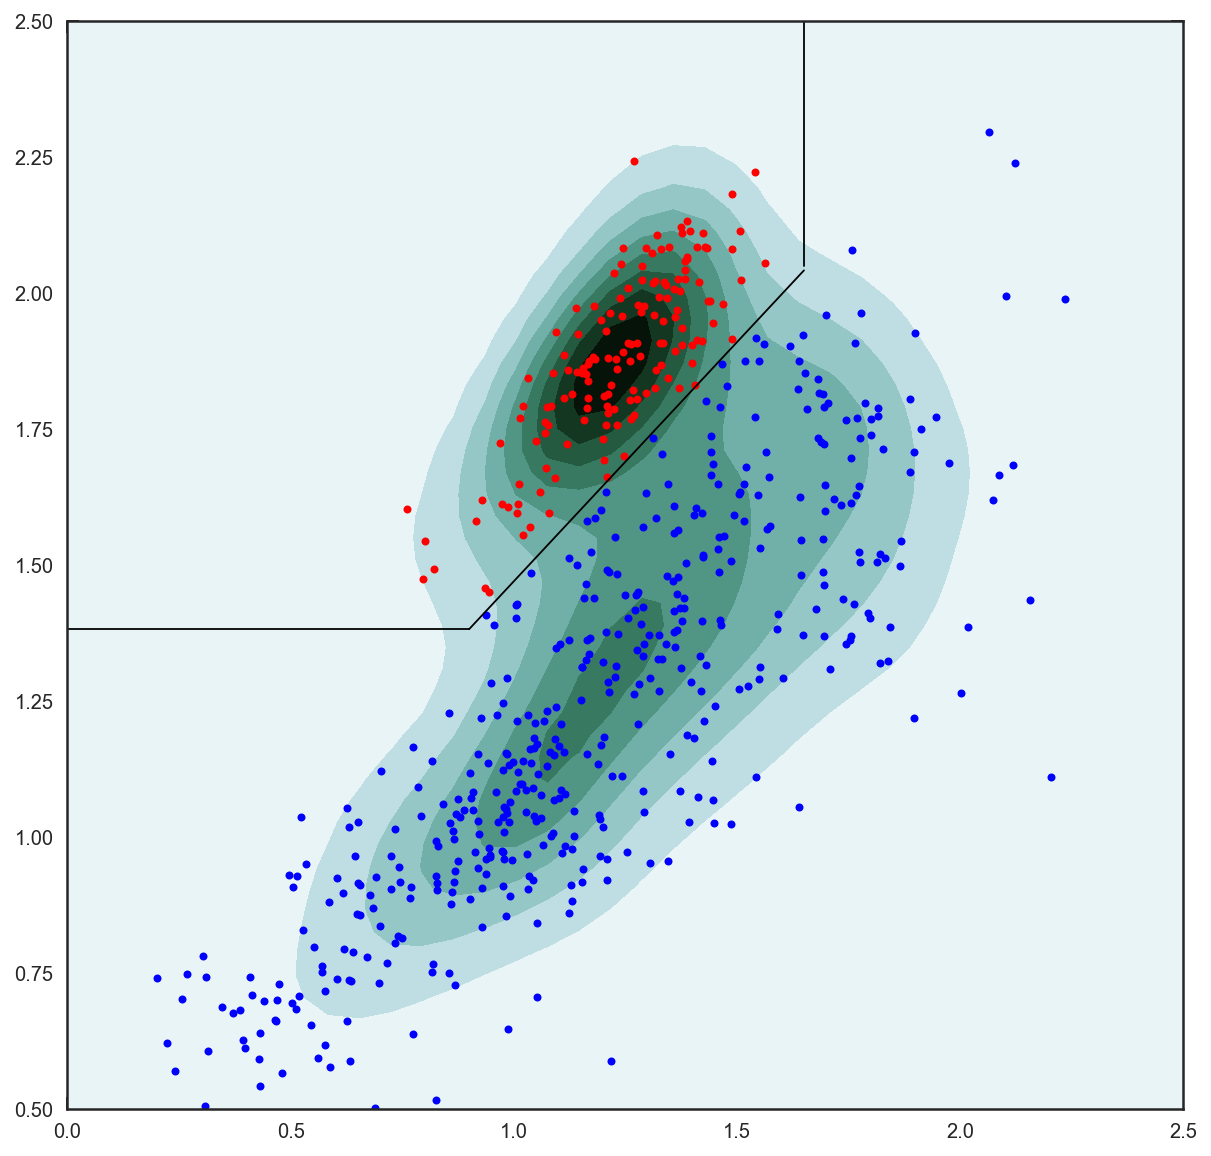

In [147]:
plt.figure(figsize=[10,10])
sea.kdeplot(VJ_all,UV_all,kernel='epa',shade=True,cmap=cmap)
plt.plot(Color(gndsamp.query('UVJ == "Q"').L155.values,gndsamp.query('UVJ == "Q"').L161.values),
         Color(gndsamp.query('UVJ == "Q"').L153.values,gndsamp.query('UVJ == "Q"').L155.values),'ro',ms=4)
plt.plot(Color(gsdsamp.query('UVJ == "Q"').L155.values,gsdsamp.query('UVJ == "Q"').L161.values),
         Color(gsdsamp.query('UVJ == "Q"').L153.values,gsdsamp.query('UVJ == "Q"').L155.values),'ro',ms=4)

plt.plot(Color(gndsamp.query('UVJ == "S"').L155.values,gndsamp.query('UVJ == "S"').L161.values),
         Color(gndsamp.query('UVJ == "S"').L153.values,gndsamp.query('UVJ == "S"').L155.values),'bo',ms=4)
plt.plot(Color(gsdsamp.query('UVJ == "S"').L155.values,gsdsamp.query('UVJ == "S"').L161.values),
         Color(gsdsamp.query('UVJ == "S"').L153.values,gsdsamp.query('UVJ == "S"').L155.values),'bo',ms=4)
plt.plot([0,.9],[1.382,1.382],'k',lw=.9)
plt.plot([1.65,1.65],[2.05,2.5],'k',lw=.9)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=.9)
plt.axis([0,2.5,.5,2.5])
plt.legend(loc=2)
plt.show()
plt.close()


In [148]:
print('Star-forming N = {0}'.format(len(gsdsamp.query('UVJ == "S"')) + len(gndsamp.query('UVJ == "S"'))))
print('Quiescent N = {0}'.format(len(gsdsamp.query('UVJ == "Q"')) + len(gndsamp.query('UVJ == "Q"'))))

Star-forming N = 465
Quiescent N = 152


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


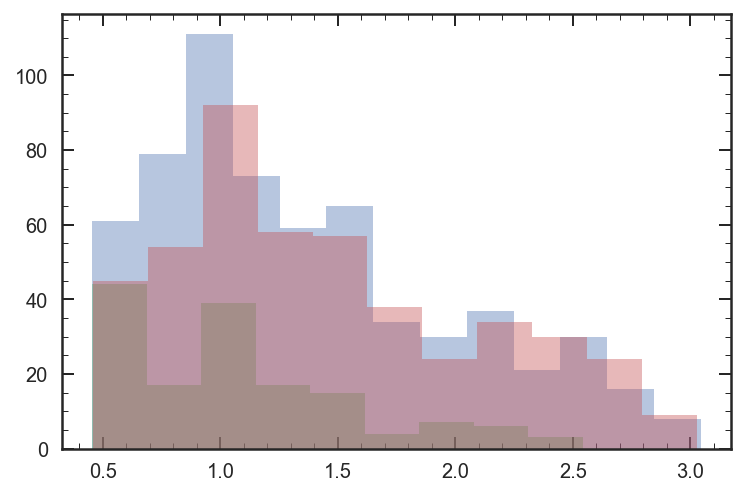

In [149]:
sea.distplot(np.append(gsdsamp.z_max_grism_x.values,gndsamp.z_max_grism_x.values),kde=False)
sea.distplot(np.append(gsdsamp.query('UVJ == "Q"').z_max_grism_x.values,gndsamp.query('UVJ == "Q"').z_max_grism_x.values),kde=False)
sea.distplot(np.append(gsdsamp.query('UVJ == "S"').z_max_grism_x.values,gndsamp.query('UVJ == "S"').z_max_grism_x.values),kde=False)

In [125]:
from spec_exam import Gen_spec

In [129]:
sp = Gen_spec(41520,g102_min=7800)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.7.0_37_g0f040f7-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3452: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.7.0_37_g0f040f7-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3457: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.7.0_37_g0f040f7-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3458: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))
/Users/vestrada/Github/Cluster_and_field/scripts/spec_exam.py:226: RuntimeWarning: invalid value encountered in sqrt
  weight = np.exp(-(1*np.abs(BEAM.contam)*np.sqrt(ivar)))
/Users/vestrada/miniconda3/envs/astroconda

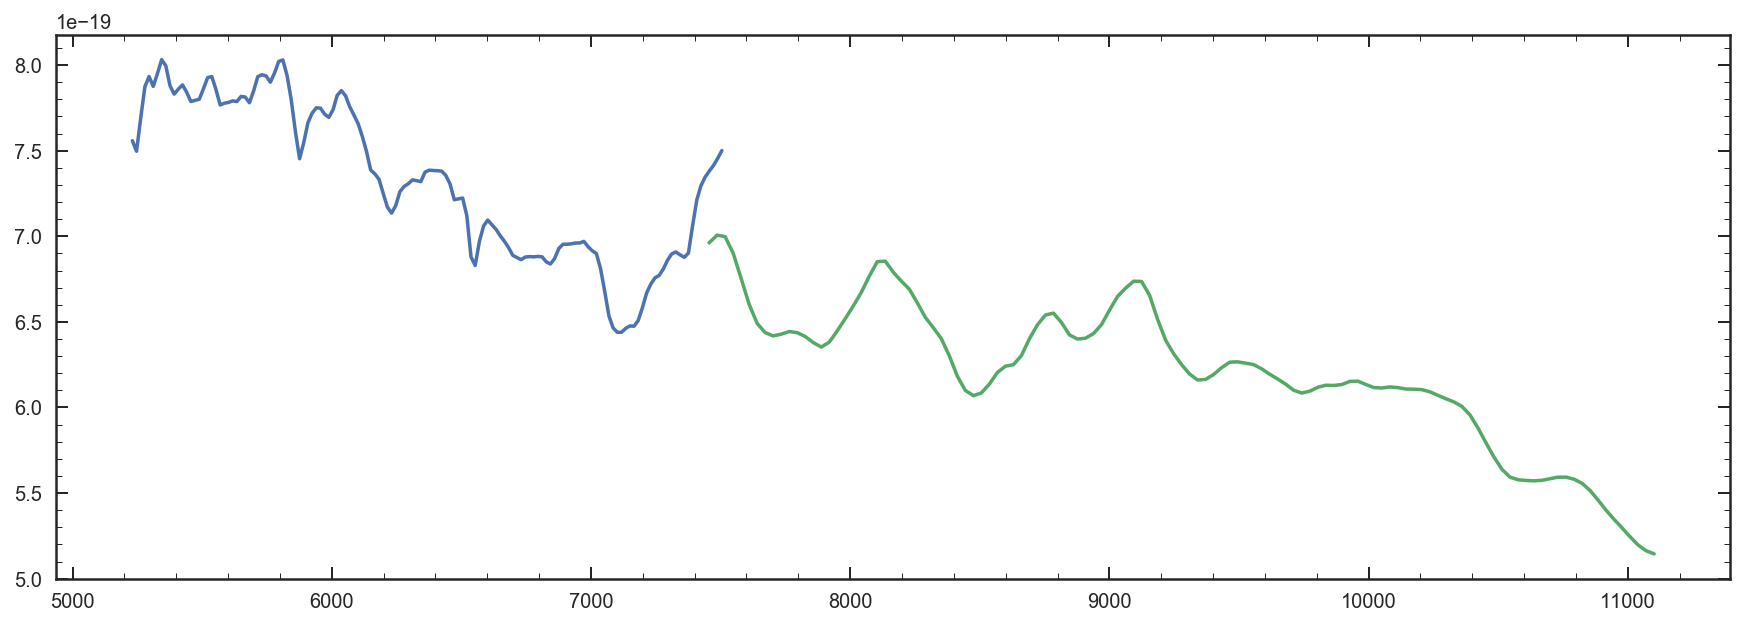

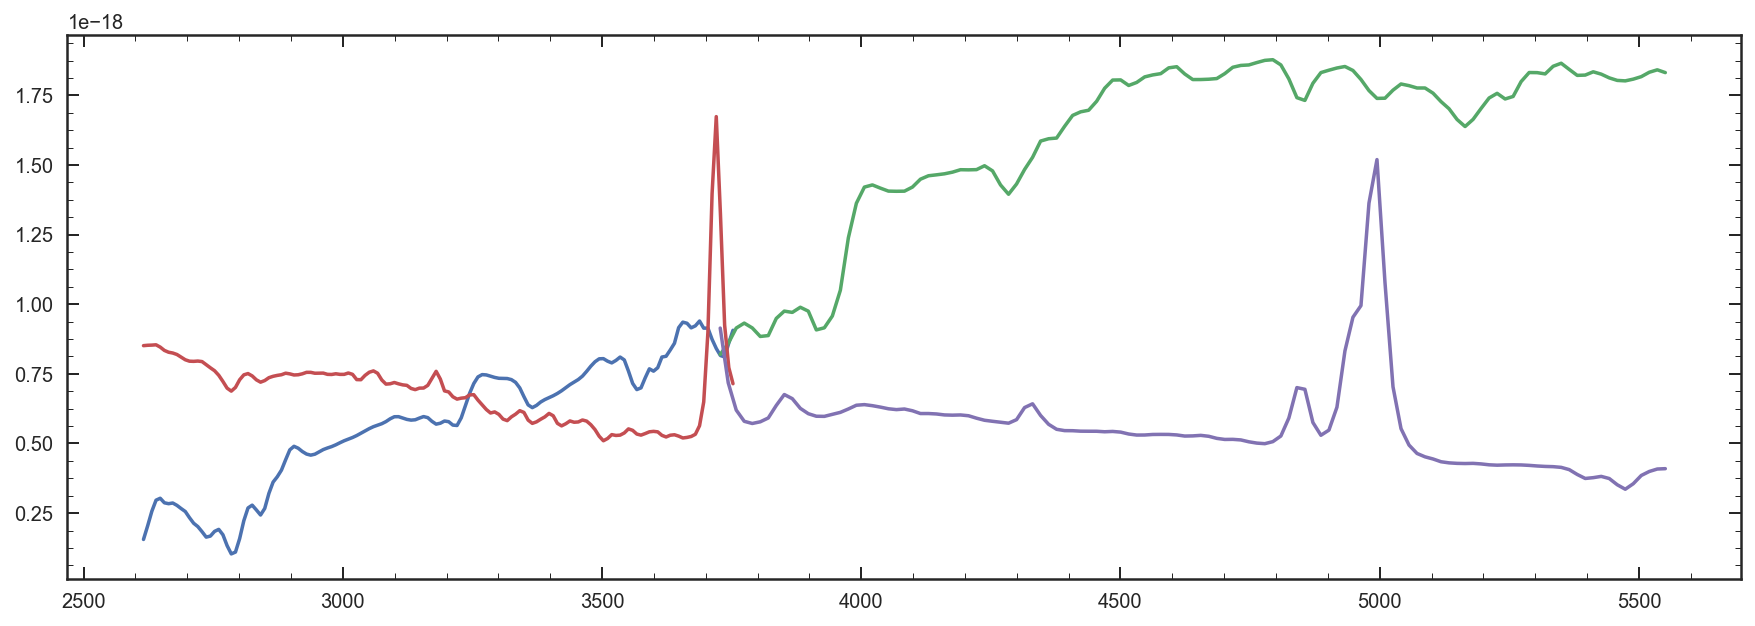

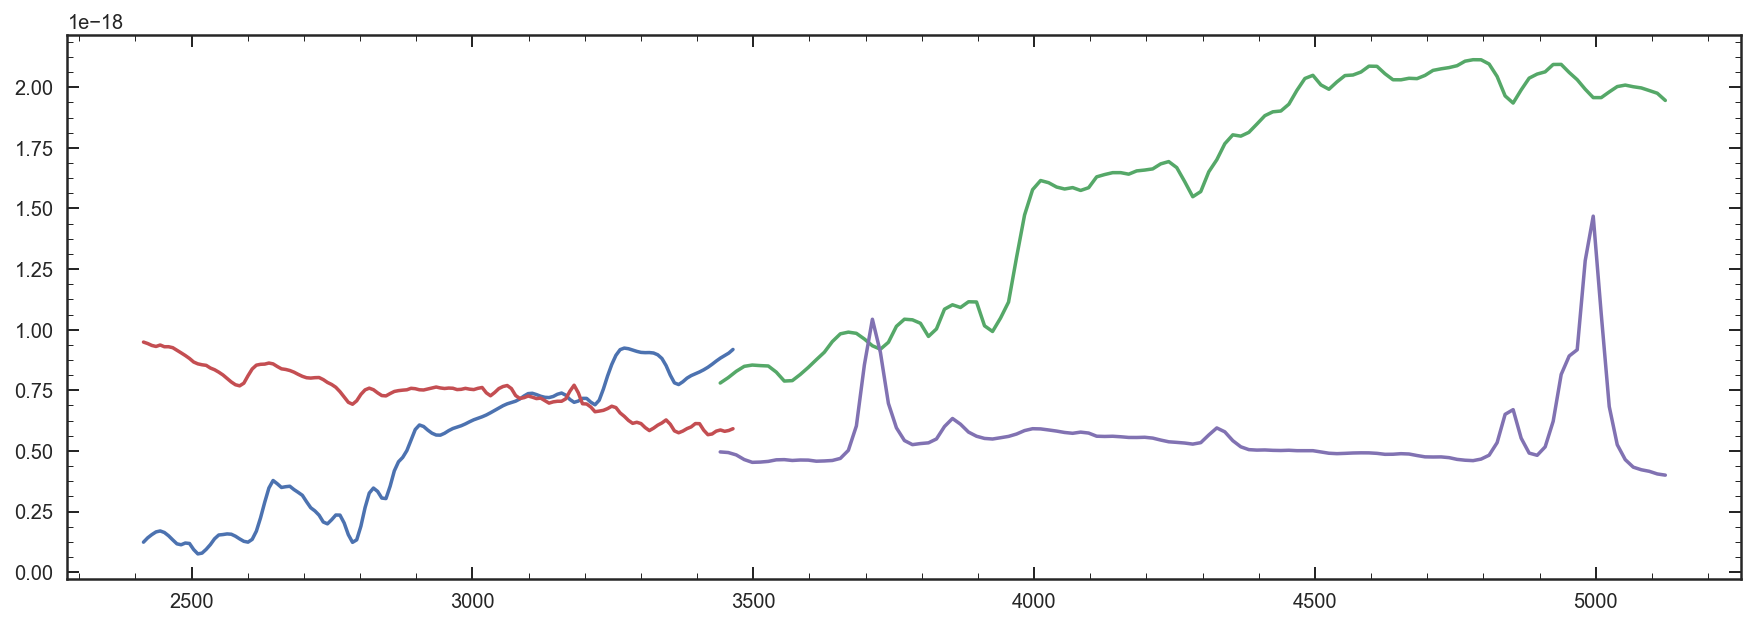

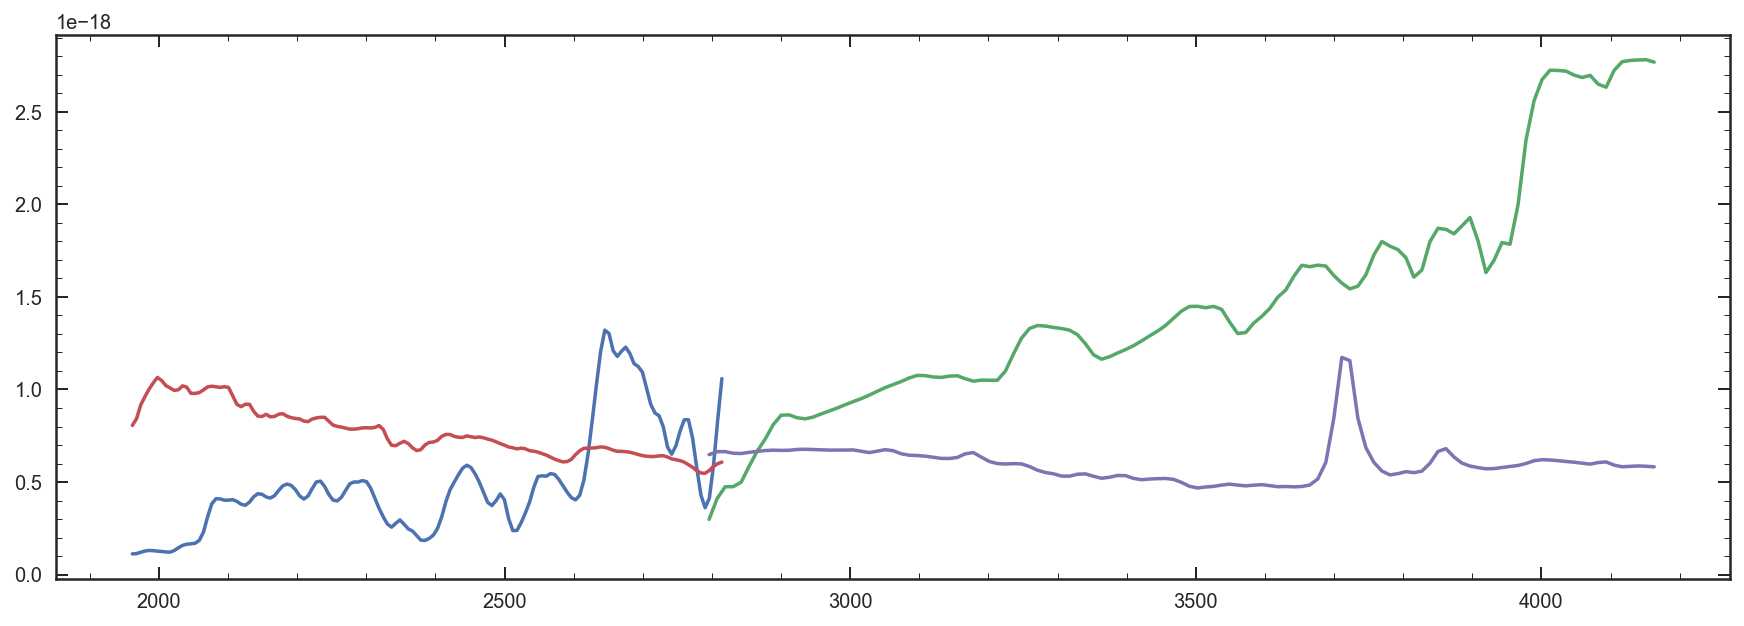

In [204]:
mwv,mfl = np.load('/Users/vestrada/fsps_models_for_fit/fsps_spec/m0.019_a2.5_dt8.0_spec.npy')
sfwv,sffl,sfer = np.loadtxt('/Users/vestrada/Downloads/all/SB1').T

sp.Gen_sim(mwv,mfl,0.5)

plt.figure(figsize=[15,5])
plt.plot(sp.g102_wv/(1.5),sp.g102_mfl)
plt.plot(sp.g141_wv/(1.5),sp.g141_mfl*.57)
sp.Gen_sim(sfwv,sffl,0.5)

# plt.plot(sp.g102_wv/(1.5),sp.g102_mfl)
# plt.plot(sp.g141_wv/(1.5),sp.g141_mfl*.57)

sp.Gen_sim(mwv,mfl,2.0)
plt.figure(figsize=[15,5])
plt.plot(sp.g102_wv/(3.0),sp.g102_mfl)
plt.plot(sp.g141_wv/(3.0),sp.g141_mfl*1.6)

sp.Gen_sim(sfwv,sffl,2.0)

plt.plot(sp.g102_wv/(3),sp.g102_mfl)
plt.plot(sp.g141_wv/(3),sp.g141_mfl*.57)

sp.Gen_sim(mwv,mfl,2.25)
plt.figure(figsize=[15,5])
plt.plot(sp.g102_wv/(3.25),sp.g102_mfl)
plt.plot(sp.g141_wv/(3.25),sp.g141_mfl*1.7)

sp.Gen_sim(sfwv,sffl,2.25)

plt.plot(sp.g102_wv/(3.25),sp.g102_mfl)
plt.plot(sp.g141_wv/(3.25),sp.g141_mfl*.57)

sp.Gen_sim(mwv,mfl,3)
plt.figure(figsize=[15,5])
plt.plot(sp.g102_wv/(4),sp.g102_mfl)
plt.plot(sp.g141_wv/(4),sp.g141_mfl*1.7)

sp.Gen_sim(sfwv,sffl,3)

plt.plot(sp.g102_wv/(4),sp.g102_mfl)
plt.plot(sp.g141_wv/(4),sp.g141_mfl*.57)

In [198]:
tok = (gndsamp['Hb_EQW'] > 10) & (gndsamp['OIII_EQW'] > 40) & \
    (gndsamp['Hb_EQW']/gndsamp['Hb_EQW_ERR'] > 3) & \
    (gndsamp['OIII_EQW']/gndsamp['OIII_EQW_ERR'] > 3)
print("There are %d objects which fit these criteria" % (np.sum(tok)))
pd.options.display.max_rows=9999
display(gndsamp.loc[tok])
pd.options.display.max_rows=10
# print(tok)

There are 13 objects which fit these criteria


,phot_id_x,grism_id_x,jh_mag_x,z_spec_x,z_peak_phot,z_phot_l95,z_phot_l68,z_phot_u68,z_phot_u95,z_max_grism_x,...,n_271,L272,n_272,L273,n_273,L274,n_274,L275,n_275,UVJ
1048,14850,b'GN7-G102_14850',21.559,1.2230,1.1634,1.128,1.140,1.188,1.210,1.2200,...,10.0,3.565780,12.0,4.866590,12.0,5.080940,12.0,20.56650,7.0,S
990,18224,b'GN2-G102_18224',20.108,0.9610,1.0143,0.996,1.000,1.028,1.034,0.9591,...,8.0,4.427260,10.0,6.965960,12.0,7.556840,12.0,68.50810,7.0,S
800,22815,b'GN4-G102_22815',20.978,0.8390,0.8650,0.828,0.843,0.888,0.907,0.8432,...,7.0,6.154810,8.0,7.771520,10.0,8.007720,10.0,29.77520,8.0,S
1196,26193,b'GN4-G102_26193',21.287,0.9140,0.8490,0.818,0.829,0.870,0.887,0.9175,...,7.0,2.237580,10.0,3.297660,10.0,3.505860,12.0,17.67430,7.0,S
897,30588,b'GN5-G102_30588',20.219,-1.0000,0.2996,0.287,0.291,0.309,0.312,0.7083,...,4.0,3.575660,6.0,4.628550,8.0,4.859160,8.0,36.45820,7.0,S
81,31245,b'GN3-G102_31245',21.127,0.9050,0.9382,0.897,0.909,0.969,0.987,0.9079,...,7.0,5.225430,10.0,6.658530,10.0,6.859940,12.0,25.66300,7.0,S
831,34251,b'GN5-G102_34251',21.939,-1.0000,1.2825,1.136,1.273,1.315,1.327,1.2558,...,10.0,1.554710,12.0,2.074540,12.0,2.177070,12.0,14.23990,7.0,S
307,34708,b'GN3-G102_34708',21.202,1.0285,0.9591,0.923,0.940,0.978,0.992,0.9367,...,8.0,5.774960,10.0,7.520290,12.0,7.800370,12.0,28.27290,8.0,S
142,34747,b'GN5-G102_34747',22.548,-1.0000,0.8836,0.799,0.831,0.946,1.029,1.1522,...,8.0,0.263000,10.0,0.499846,12.0,0.551624,12.0,6.71828,7.0,S
447,35090,b'GN3-G102_35090',20.041,-1.0000,0.9628,0.917,0.940,0.984,0.994,0.9868,...,8.0,1.750440,10.0,2.813960,12.0,3.034970,12.0,60.88090,7.0,Q


In [199]:
SearchID = 37533

files_all = glob('%s/*/*/*%s*' % (combineddir, SearchID))

print('There are a total of %d files for the combined spectrum of this object.' % (len(files_all)))

There are a total of 14 files for the combined spectrum of this object.


In [200]:
files_png = glob('%s/*/*/*%s*.png' % (combineddir, SearchID))
print('Found %d PNG files.' % len(files_png))
for file in files_png:
    print(file)

Found 6 PNG files.
/Users/vestrada/Data/CLEAR/RELEASE_v1.0.0/COMBINED/2D/PNG/GN1-G102_37533_stack.png
/Users/vestrada/Data/CLEAR/RELEASE_v1.0.0/COMBINED/LINEFIT/CHAIN_PNG/GN1-G102_37533.linefit.chain.png
/Users/vestrada/Data/CLEAR/RELEASE_v1.0.0/COMBINED/LINEFIT/PNG/GN1-G102_37533.linefit.png
/Users/vestrada/Data/CLEAR/RELEASE_v1.0.0/COMBINED/ZFIT/2D_PNG/GN1-G102_37533.new_zfit.2D.png
/Users/vestrada/Data/CLEAR/RELEASE_v1.0.0/COMBINED/ZFIT/PNG/GN1-G102_37533.new_zfit.png
/Users/vestrada/Data/CLEAR/RELEASE_v1.0.0/COMBINED/ZFIT/TILT_PNG/GN1-G102_37533.new_zfit_tilt.png


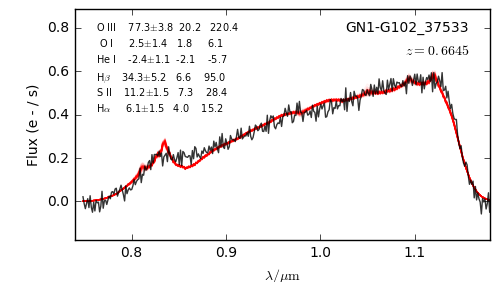

In [203]:
Image(files_png[2])

In [13]:
filelist = glob(hpath + 'Clear_data/s_flt_files/*flt.fits')
for i in s_cand_sup.index:
    for ii in range(len(filelist)):
        pres,pos=Source_present(filelist[ii],s_cand_sup.ra[i],s_cand_sup.dec[i])
        if pres == True:
            s_cand_sup.in_out[i]= 'in'
            break
            
filelist = glob(hpath + 'Clear_data/n_flt_files/*flt.fits')
for i in n_cand_sup.index:
    for ii in range(len(filelist)):
        pres,pos=Source_present(filelist[ii],n_cand_sup.ra[i],n_cand_sup.dec[i])
        if pres == True:
            n_cand_sup.in_out[i]= 'in'
            break

            
filelist = glob(hpath + 'UDS_data/uds_flt_files/*flt.fits')
for i in u_cand.index:
    for ii in range(len(filelist)):
        pres,pos=Source_present(filelist[ii],u_cand.ra[i],u_cand.dec[i])
        if pres == True:
            u_cand.in_out[i]= 'in'
            break

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [15]:
s_cand_sup = s_cand_sup.query('in_out == "in"')
n_cand_sup = n_cand_sup.query('in_out == "in"')
u_cand = u_cand.query('in_out == "in"')

In [30]:
s_cand_sup.to_pickle('../dataframes/galaxy_frames/s_sup_candidates.pkl')
n_cand_sup.to_pickle('../dataframes/galaxy_frames/n_sup_candidates.pkl')
u_cand.to_pickle('../dataframes/galaxy_frames/u_candidates.pkl')

In [2]:
s_cand_sup= pd.read_pickle('../dataframes/galaxy_frames/s_sup_candidates.pkl')
n_cand_sup= pd.read_pickle('../dataframes/galaxy_frames/n_sup_candidates.pkl')
u_cand= pd.read_pickle('../dataframes/galaxy_frames/u_candidates.pkl')

In [25]:
s_in_out = np.repeat('out',len(s_cand_sup.index))
filelist = glob(hpath + '3dhst/s_flt_files/*flt.fits')
for i in range(len(s_cand_sup.index)):
    for ii in range(len(filelist)):
        pres,pos=Source_present(filelist[ii],s_cand_sup.ra[s_cand_sup.index[i]],s_cand_sup.dec[s_cand_sup.index[i]])
        if pres == True:
            s_in_out[i]= 'in'
            break
            
n_in_out = np.repeat('out',len(n_cand_sup.index))          
filelist = glob(hpath + '/3dhst/n_flt_files/*flt.fits')
for i in range(len(n_cand_sup.index)):
    for ii in range(len(filelist)):
        pres,pos=Source_present(filelist[ii],n_cand_sup.ra[n_cand_sup.index[i]],n_cand_sup.dec[n_cand_sup.index[i]])
        if pres == True:
            n_in_out[i]= 'in'
            break

u_in_out = np.repeat('out',len(u_cand.index))                  
filelist = glob(hpath + 'UDS_data/uds_g141_flts/*flt.fits')
for i in range(len(u_cand.index)):
    for ii in range(len(filelist)):
        pres,pos=Source_present(filelist[ii],u_cand.ra[u_cand.index[i]],u_cand.dec[u_cand.index[i]])
        if pres == True:
            u_in_out[i]= 'in'
            break

In [29]:
s_cand_sup.in_out = s_in_out
n_cand_sup.in_out = n_in_out
u_cand.in_out = u_in_out

# remove AGN

In [3]:
s_cand_sup= pd.read_pickle('../dataframes/galaxy_frames/s_sup_candidates.pkl')
n_cand_sup= pd.read_pickle('../dataframes/galaxy_frames/n_sup_candidates.pkl')
u_cand= pd.read_pickle('../dataframes/galaxy_frames/u_candidates.pkl')

In [4]:
agn_ra=fits.open('../../../Clear_data/AGN_catalog/tbl04.fits')[1].data['GOODSS_RA']
agn_dec=fits.open('../../../Clear_data/AGN_catalog/tbl04.fits')[1].data['GOODSS_DEC']

In [18]:
def Match_agn(gal_ra, gal_dec, agn_ra, agn_dec):
    r = (1. / 60 / 60) * 1    
    in_out = np.repeat('in',len(gal_ra))          
    for i in range(len(gal_ra)):
        cosr = np.sin(np.radians(gal_dec[i])) * np.sin(np.radians(agn_dec)) + np.cos(np.radians(gal_dec[i]))\
                * np.cos(np.radians(agn_dec)) * np.cos(np.radians(gal_ra[i]) - np.radians(agn_ra))
        rad = np.arccos(cosr)
        rad = np.degrees(rad)
        for ii in range(len(rad)):
            if rad[ii] < r:
                in_out[i]= 'out'
    return in_out

In [19]:
south_agn = Match_agn(s_cand_sup['ra'].values,s_cand_sup['dec'].values,agn_ra,agn_dec)

In [21]:
n_agn_cat=Table.read('../../../Clear_data/AGN_catalog/apjs523032t3_mrt.txt',format='ascii')

In [22]:
RA=np.array([n_agn_cat['RAh'].data, n_agn_cat['RAm'].data,n_agn_cat['RAs'].data]).T
DEC=np.array([n_agn_cat['DEd'].data,n_agn_cat['DEm'].data,n_agn_cat['DEs'].data]).T

def Convert_RA_DEC_to_deg(ra,dec):
    R=15*(ra[0]+ra[1]/60.+ra[2]/3600.)
    D=dec[0]+dec[1]/60.+dec[2]/3600.
    return R,D

nra,ndec=np.zeros([2,len(RA)])

for i in range(len(RA)):
    nra[i],ndec[i]=Convert_RA_DEC_to_deg(RA[i],DEC[i])

In [23]:
north_agn = Match_agn(n_cand_sup['ra'].values,n_cand_sup['dec'].values,nra,ndec)

In [25]:
s_cand_sup.in_out = south_agn
n_cand_sup.in_out = north_agn

In [26]:
s_cand_sup = s_cand_sup.query('in_out == "in"')
n_cand_sup = n_cand_sup.query('in_out == "in"')

In [27]:
s_cand_sup.to_pickle('../dataframes/galaxy_frames/s_sup_candidates.pkl')
n_cand_sup.to_pickle('../dataframes/galaxy_frames/n_sup_candidates.pkl')

# Remove know sample < 1.4

In [30]:
galDB = pd.read_pickle('../../Quiescent_analysis/data/sgal_param_DB.pkl')

In [37]:
sgalid =[]
ngalid =[]

for i in galDB.index:
    if galDB.gids[i][0] == 's':
        sgalid.append(galDB.ids[i])
    if galDB.gids[i][0] == 'n':    
        ngalid.append(galDB.ids[i])


In [44]:
s_in_out = np.repeat('in',len(s_cand_sup.index))          
for i in range(len(s_cand_sup.index)):
    if s_cand_sup.gids[s_cand_sup.index[i]] in sgalid:
        s_in_out[i] = 'out'
        
n_in_out = np.repeat('in',len(n_cand_sup.index))          
for i in range(len(n_cand_sup.index)):
    if n_cand_sup.gids[n_cand_sup.index[i]] in ngalid:
        n_in_out[i] = 'out'

In [46]:
s_cand_sup.in_out = s_in_out
n_cand_sup.in_out = n_in_out

In [47]:
s_cand_sup = s_cand_sup.query('in_out == "in"')
n_cand_sup = n_cand_sup.query('in_out == "in"')

In [48]:
s_cand_sup.to_pickle('../dataframes/galaxy_frames/s_sup_candidates.pkl')
n_cand_sup.to_pickle('../dataframes/galaxy_frames/n_sup_candidates.pkl')

# Remove sample with zspec

In [56]:
s_in_out = np.repeat('in',len(s_cand_sup.index))          
for i in range(len(s_cand_sup.index)):
    if s_cand_sup.zspec[s_cand_sup.index[i]] != -1:
        s_in_out[i] = 'out'

n_in_out = np.repeat('in',len(n_cand_sup.index))          
for i in range(len(n_cand_sup.index)):
    if n_cand_sup.zspec[n_cand_sup.index[i]] != -1:
        n_in_out[i] = 'out'

In [59]:
s_cand_sup.in_out = s_in_out
n_cand_sup.in_out = n_in_out

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [60]:
s_cand_sup = s_cand_sup.query('in_out == "in"')
n_cand_sup = n_cand_sup.query('in_out == "in"')

In [61]:
s_cand_sup.to_pickle('../dataframes/galaxy_frames/s_sup_candidates.pkl')
n_cand_sup.to_pickle('../dataframes/galaxy_frames/n_sup_candidates.pkl')

# Remove low magnitude objects

In [19]:
s_cand_sup= pd.read_pickle('../dataframes/galaxy_frames/s_sup_candidates.pkl')
n_cand_sup= pd.read_pickle('../dataframes/galaxy_frames/n_sup_candidates.pkl')
s_cand = pd.read_pickle('../dataframes/galaxy_frames/s_candidates.pkl')

In [11]:
goods_s=Table.read('/Users/Vince.ec/Clear_data/goodss_mosaic/goodss_3dhst.v4.3.cat',format='ascii').to_pandas()
goods_n=Table.read('/Users/Vince.ec/Clear_data/goodsn_mosaic/goodsn_3dhstP.cat',format='ascii').to_pandas()

In [25]:
for i in n_cand_sup.index:
    print(Mag(goods_n['f_F125W'][i]))


26.781083474987703
27.305962587719765
27.215542580475145
22.379508843085645
21.910454900241987
26.56836426449067
27.531068935664432
26.300723496828457
27.14677544190599
25.880963180955625
22.58211187773431
22.869676735790215
23.568437774921723
22.74527322166506
26.200262739787227
25.842352747292228
26.891214323547427
27.41034545924609
27.153201447815007
27.012999806350262
27.613826878825414
27.641115328182522
21.85708212488621
26.897572854190663
22.983651650846248
26.82316902013147
27.02540429098586
26.965707677574
27.73706245975177
26.423675595318766
26.90521113968904
27.7827584275741
26.226550078375404
28.086033488318613
27.31706099660542
25.238509992004126
23.205082699688656
27.08023785094666
26.792199412600564
27.3950486032157
26.80812764742189
27.04933397479308
27.131350260382238
26.930263965213125
27.002807681891117
26.81039765023833
27.31588738621712
26.65317665983861
26.897423253092064
27.031177047409564
26.776451294476622
27.32023977621254
22.28360759314524
26.97382245521681
2

# Get photometry

In [2]:
goods_s=Table.read('/Users/Vince.ec/Clear_data/goodss_mosaic/goodss_3dhst.v4.3.cat',format='ascii').to_pandas()
goods_n=Table.read('/Users/Vince.ec/Clear_data/goodsn_mosaic/goodsn_3dhstP.cat',format='ascii').to_pandas()

# s_cand = pd.read_pickle('../dataframes/galaxy_frames/s_candidates.pkl')
# n_cand = pd.read_pickle('../dataframes/galaxy_frames/n_candidates.pkl')

In [3]:
gs_keys = np.array(goods_s.keys())
gn_keys = np.array(goods_n.keys())

In [4]:
sflux_keys = []
serror_keys = []

for i in gs_keys:
    if i[0:2] == 'f_':
        sflux_keys.append(i)
    if i[0:2] == 'e_':
        serror_keys.append(i)
        
nflux_keys = []
nerror_keys = []

for i in gn_keys:
    if i[0:2] == 'f_':
        nflux_keys.append(i)
    if i[0:2] == 'e_':
        nerror_keys.append(i)

In [9]:
print(nflux_keys)

['f_F160W', 'f_U', 'f_F435W', 'f_B', 'f_G', 'f_V', 'f_F606W', 'f_R', 'f_Rs', 'f_I', 'f_F775W', 'f_Z', 'f_F850LP', 'f_F125W', 'f_J', 'f_F140W', 'f_H', 'f_Ks', 'f_IRAC1', 'f_IRAC2', 'f_IRAC3', 'f_IRAC4']


In [5]:
s_trans,sez_code=np.loadtxt('/Users/Vince.ec/catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/Eazy/goodss_3dhst.v4.1.translate',dtype=str).T
n_trans,nez_code=np.loadtxt('/Users/Vince.ec/catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/Eazy/goodsn_3dhst.v4.1.translate',dtype=str).T

In [8]:
s_codes = []
s_keys = []
s_ekeys = []
n_codes = []
n_keys = []
n_ekeys = []

for i in range(len(sflux_keys)):
    if sez_code[np.argwhere(s_trans == sflux_keys[i])].size >0:
        s_codes.append(int(sez_code[np.argwhere(s_trans == sflux_keys[i])][0][0][1:]))
        s_keys.append(sflux_keys[i])
        s_ekeys.append(serror_keys[i])
        
for i in range(len(nflux_keys)):
    if nez_code[np.argwhere(n_trans == nflux_keys[i])].size >0:
        n_codes.append(int(nez_code[np.argwhere(n_trans == nflux_keys[i])][0][0][1:]))
        n_keys.append(nflux_keys[i])
        n_ekeys.append(nerror_keys[i])

In [43]:
for i in s_cand.index:
    filt = []
    ez_key = []
    eff_wvs = []
    phot = []
    phot_err = []
    for ii in range(len(s_codes)):
        if goods_s[s_keys[ii]][i] > 0:
            sw,sf,effwv=Get_Sensitivity(s_codes[ii])
            Clam = 3E18 / effwv **2 * 10**((-1.1)/2.5-29)
            filt.append(s_keys[ii][2:])
            ez_key.append(s_codes[ii])
            eff_wvs.append(effwv)
            phot.append(Clam * goods_s[s_keys[ii]][i])
            phot_err.append(Clam * goods_s[s_ekeys[ii]][i])
     
    sw,sf,effwv=Get_Sensitivity(201)
    Clam = 3E18 / effwv **2 * 10**((-1.1)/2.5-29)
    filt.append('F098M')
    ez_key.append(201)
    eff_wvs.append(effwv)
    phot.append(Clam * goods_s['f_F098M'][i])
    phot_err.append(Clam * goods_s['e_F098M'][i])
    
    phot_db = pd.DataFrame({'filter' : filt, 'EAZY_key' : ez_key, 'eff_wv' : eff_wvs,
                           'phot' : phot, 'phot_err' : phot_err})
    phot_db.to_pickle('../dataframes/phot/gs_{0}_phot.pkl'.format(s_cand.gids[i]))
    
    
for i in n_cand.index:
    filt = []
    ez_key = []
    eff_wvs = []
    phot = []
    phot_err = []
    for ii in range(len(n_codes)):
        if goods_n[n_keys[ii]][i] > 0:
            sw,sf,effwv=Get_Sensitivity(n_codes[ii])
            Clam = 3E18 / effwv **2 * 10**((-1.1)/2.5-29)
            filt.append(n_keys[ii][2:])
            ez_key.append(n_codes[ii])
            eff_wvs.append(effwv)
            phot.append(Clam * goods_n[n_keys[ii]][i])
            phot_err.append(Clam * goods_n[n_ekeys[ii]][i])
            
    phot_db = pd.DataFrame({'filter' : filt, 'EAZY_key' : ez_key, 'eff_wv' : eff_wvs,
                           'phot' : phot, 'phot_err' : phot_err})
    phot_db.to_pickle('../dataframes/phot/gn_{0}_phot.pkl'.format(n_cand.gids[i]))

In [16]:
n_cand

,dec,gids,in_out,ra,zphot,zspec
6283,62.172293,6284,in,189.199728,1.7560,-1.0000
8465,62.184931,8466,in,189.156533,1.7063,-1.0000
11813,62.200346,11814,in,189.217095,1.6698,-1.0000
13116,62.206599,13117,in,189.260877,1.6337,-1.0000
21426,62.247344,21427,in,189.368121,1.4759,-1.0000
23025,62.254732,23026,in,189.032759,1.4788,-1.0000
23253,62.255761,23254,in,189.349606,1.4561,-1.0000
32690,62.307165,32691,in,189.347593,1.4266,-1.0000
33092,62.310363,33093,in,189.331982,1.4674,1.5198
37106,62.347600,37107,in,189.344334,1.6778,-1.0000


In [17]:
s_cand

,dec,gids,in_out,ra,zphot,zspec
26271,-27.790601,26272,in,53.150826,1.5716,-1.0
28318,-27.782060,28319,in,53.173671,1.7817,-1.0
29256,-27.777637,29257,in,53.147471,1.6824,-1.0
36175,-27.742284,36176,in,53.121006,1.7098,-1.0
38842,-27.729749,38843,in,53.107039,1.6766,-1.0
39011,-27.727621,39012,in,53.064240,1.6573,-1.0
39363,-27.726461,39364,in,53.062821,1.6970,-1.0
40222,-27.722957,40223,in,53.124956,1.6508,-1.0
40622,-27.721152,40623,in,53.130480,1.4913,-1.0
41147,-27.718885,41148,in,53.127925,1.6965,-1.0


In [38]:
for i in n_cand.index:
    p_file = glob('../dataframes/phot/*{0}*'.format(n_cand.gids[i]))[0]
    dat = pd.read_pickle(p_file)
    print(dat.query('filter == "F850LP"')['phot'].values)

[3.84408095e-20]
[4.23481863e-19]
[6.89412686e-20]
[1.90429397e-19]
[3.7373196e-19]
[5.30562923e-19]
[1.49544545e-19]
[2.48897002e-19]
[1.30274799e-19]
[3.14590391e-19]
[4.22947048e-19]
[3.96661115e-19]
[9.73296248e-20]
[8.12215803e-20]
[4.48057545e-20]
[3.64634188e-20]


# prelim redshift check

In [2]:
s_cand_sup= pd.read_pickle('../dataframes/galaxy_frames/s_sup_candidates.pkl')
n_cand_sup= pd.read_pickle('../dataframes/galaxy_frames/n_sup_candidates.pkl')
u_cand= pd.read_pickle('../dataframes/galaxy_frames/u_candidates.pkl')

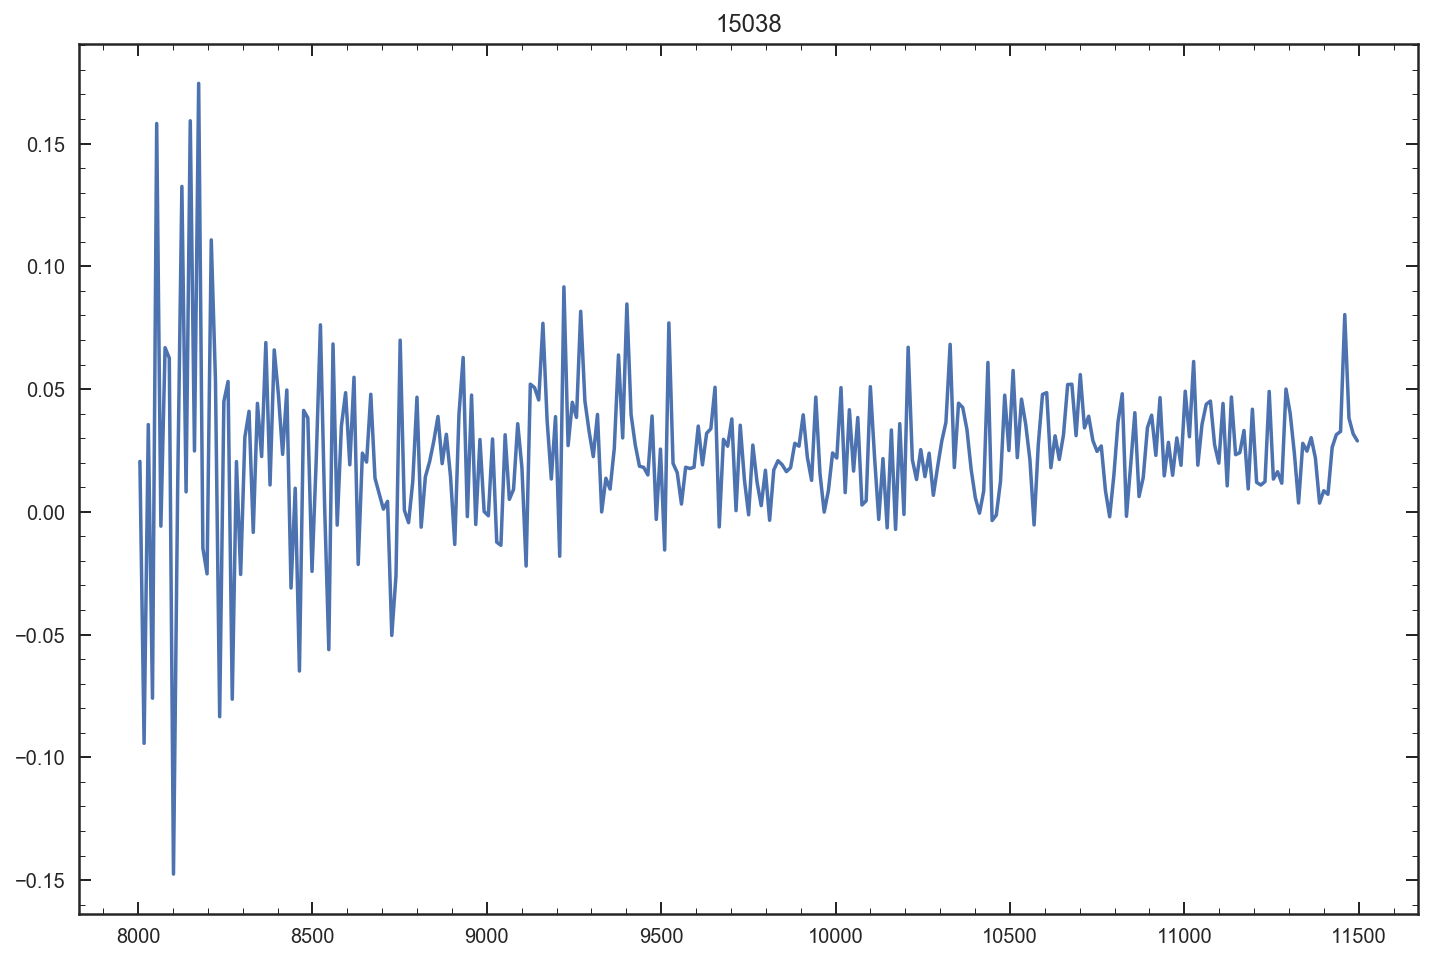

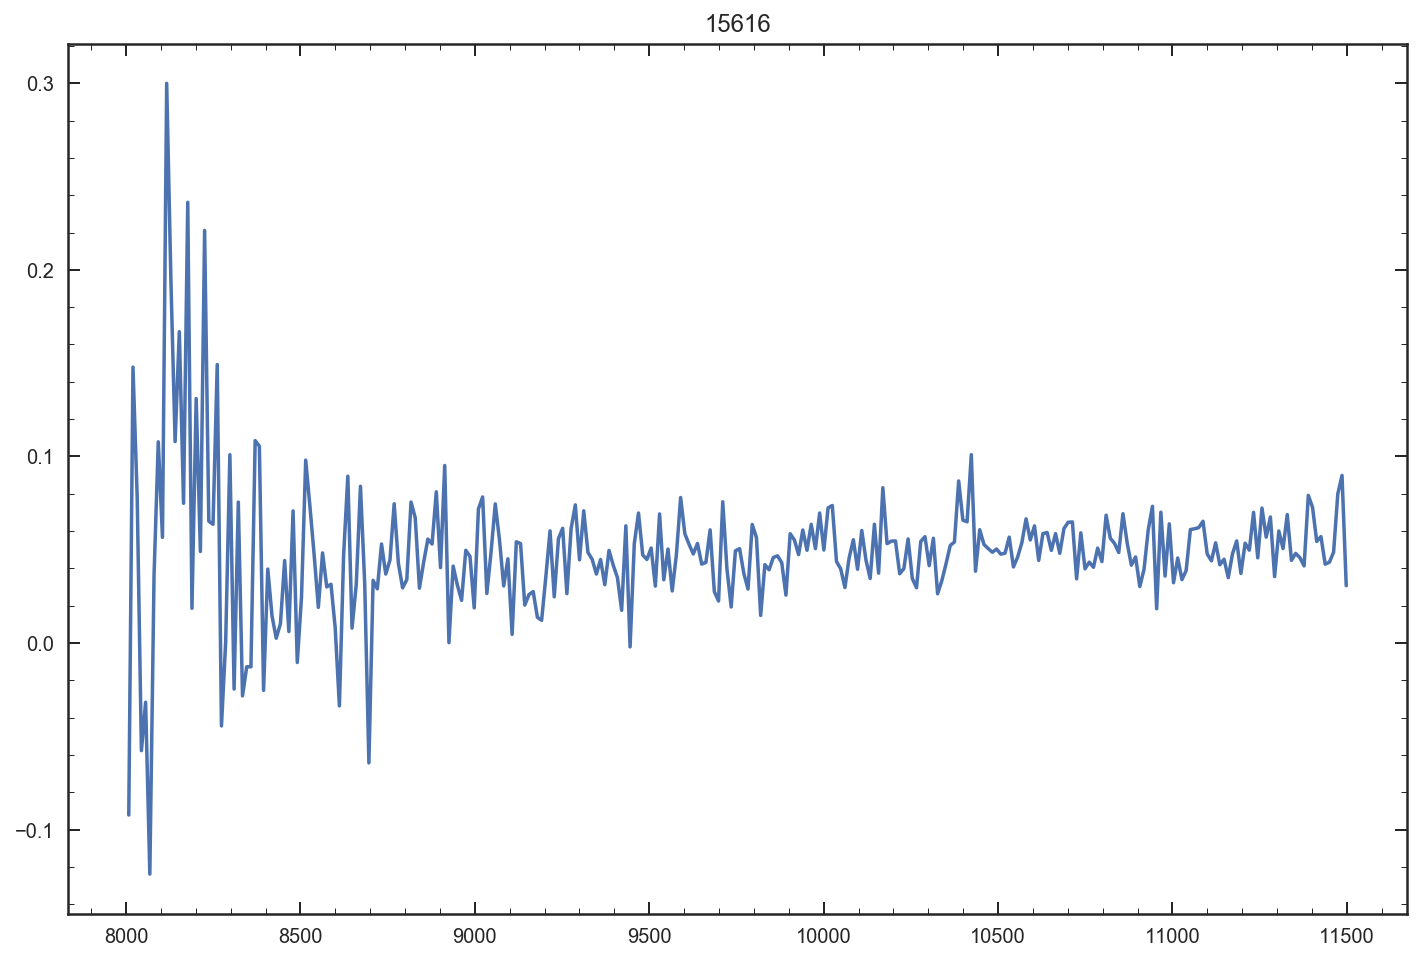

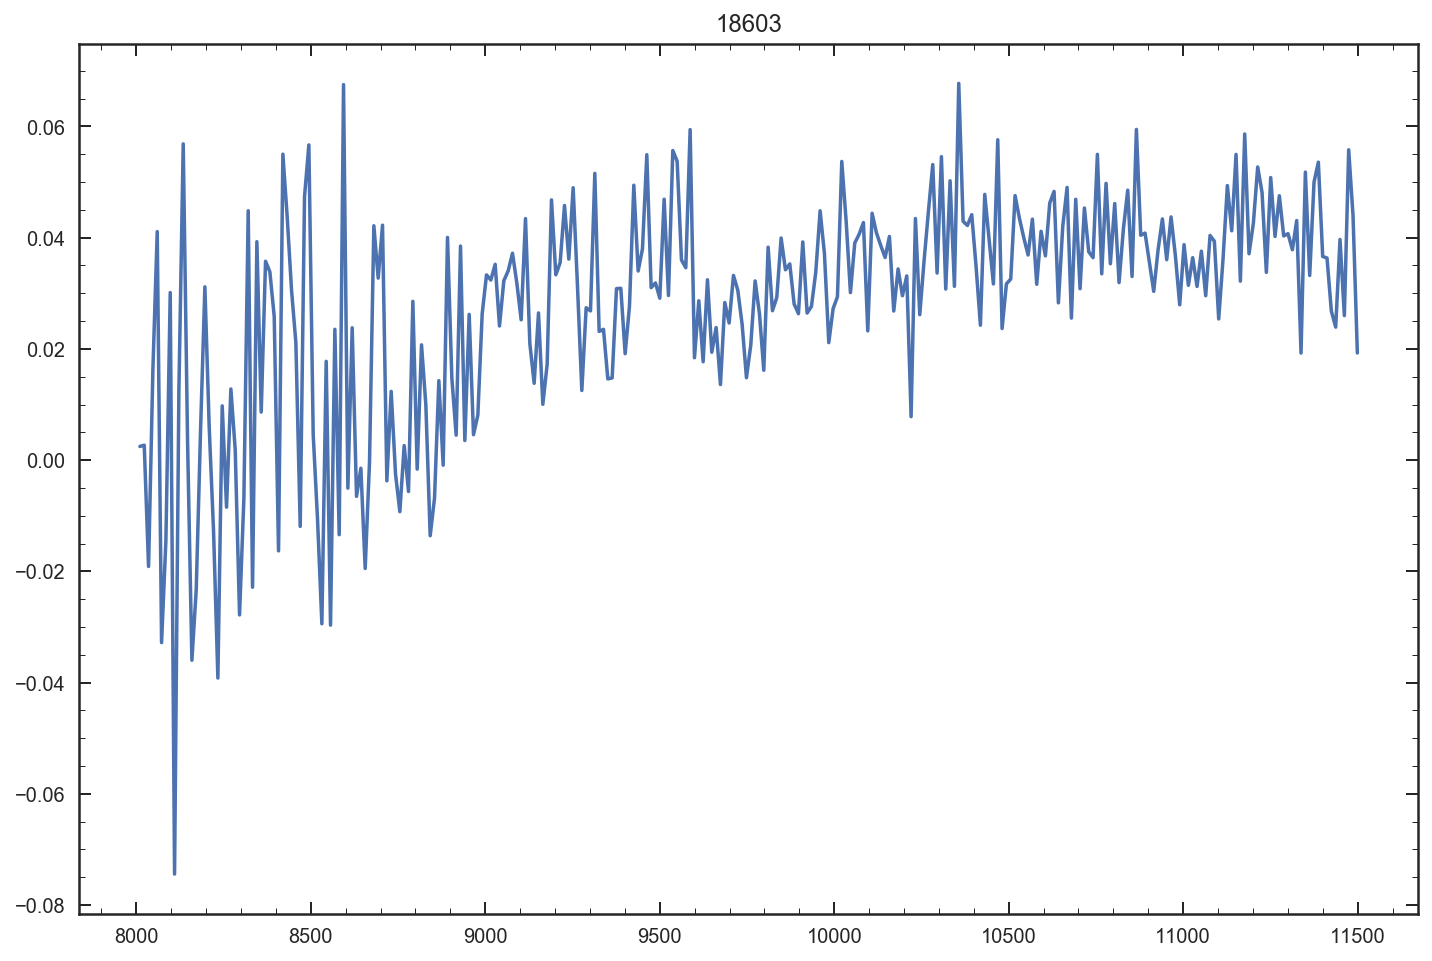

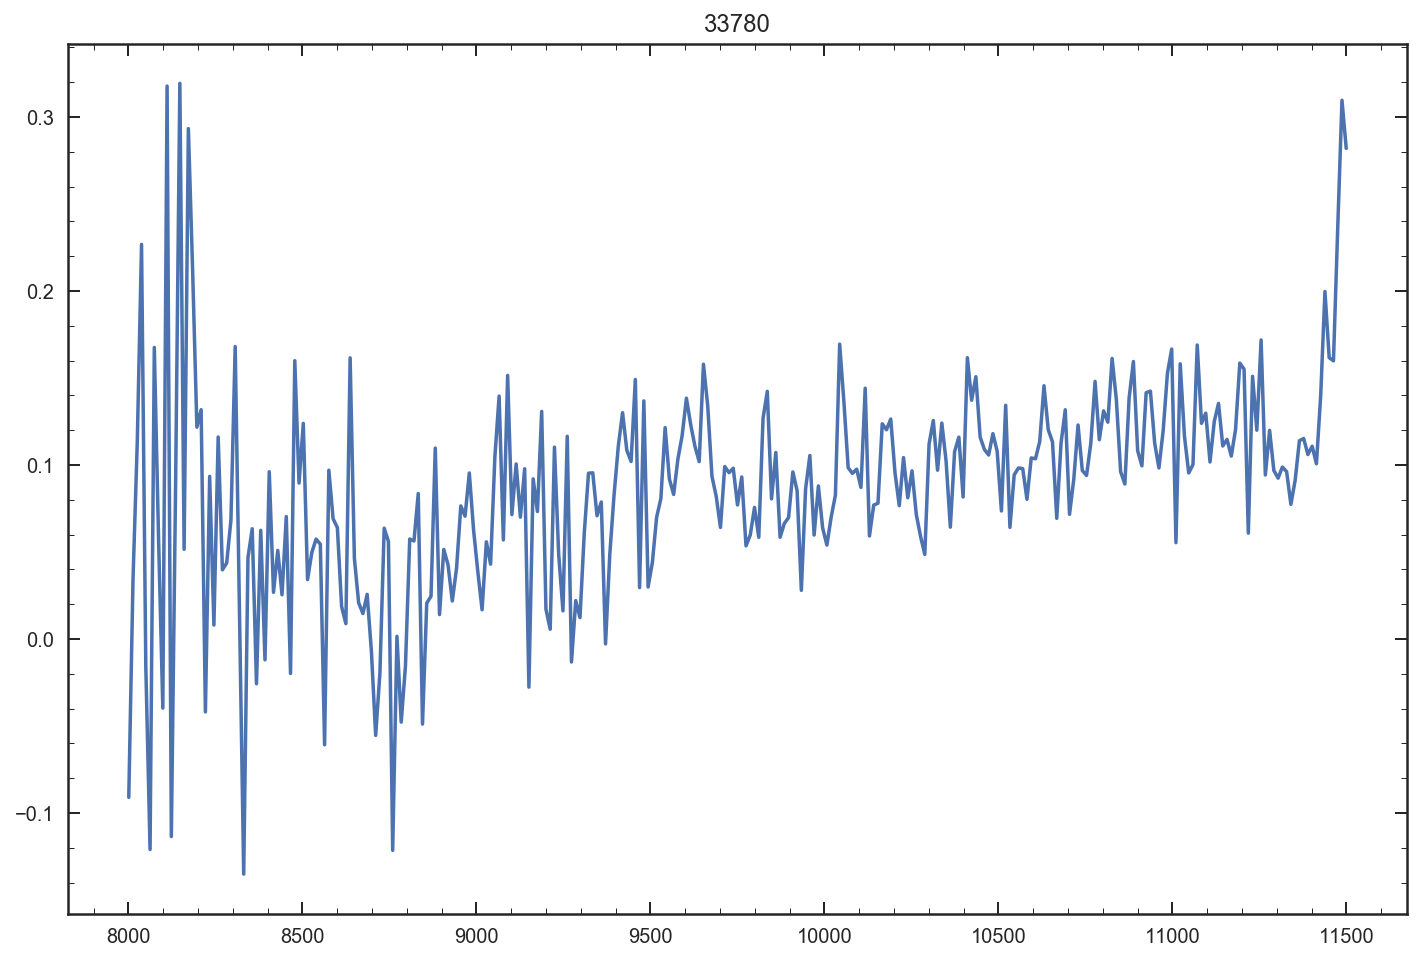

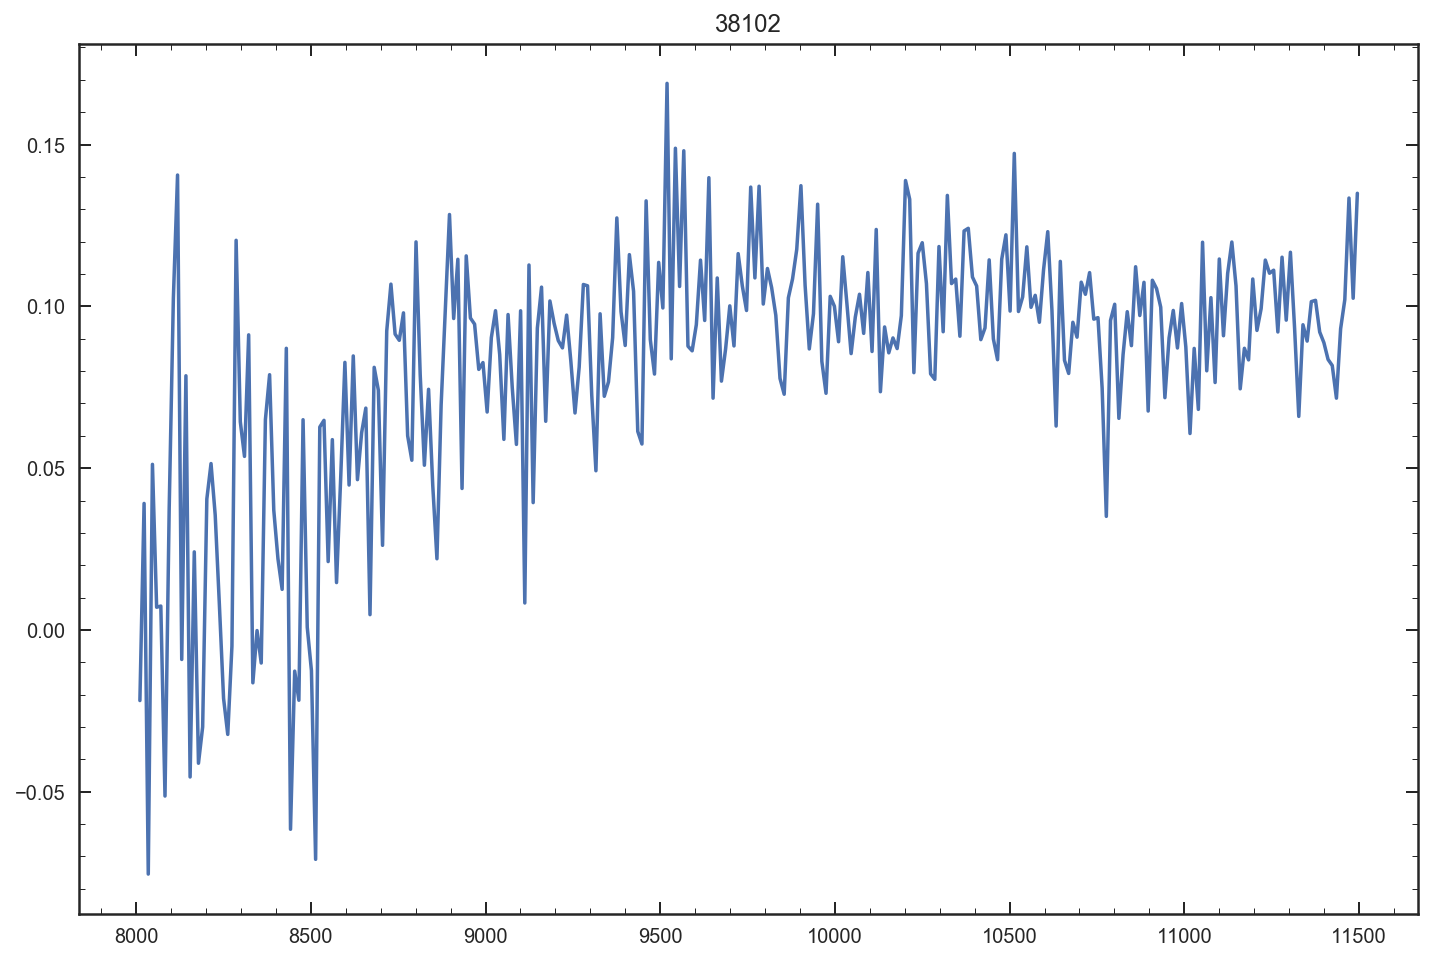

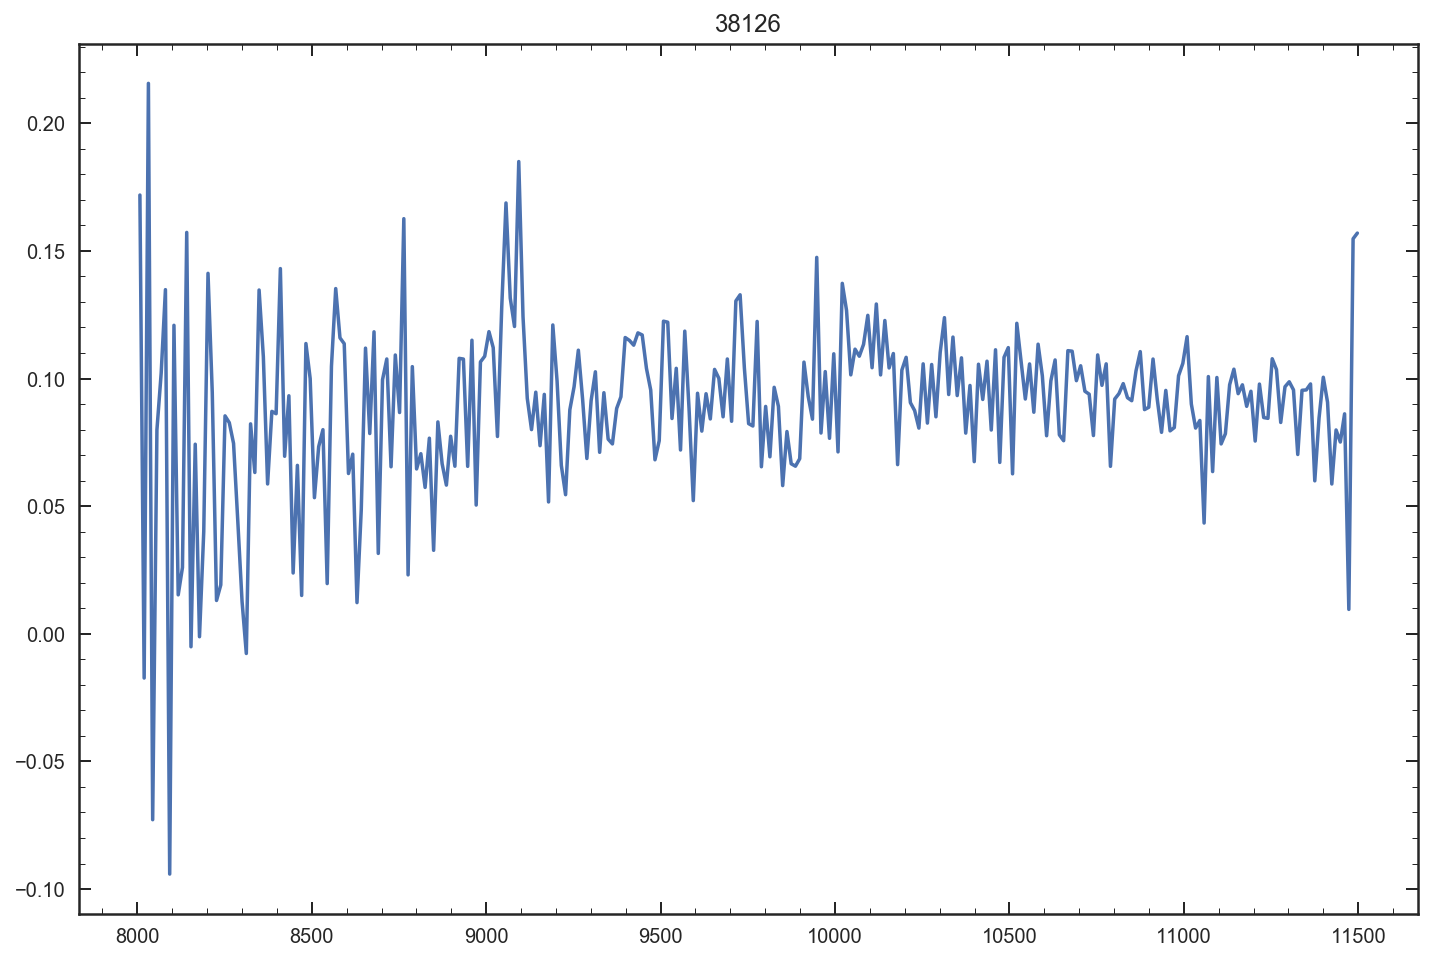

In [19]:
for i in n_cand_sup.index:
    files = glob('/Volumes/Vince_research/Extractions/COMBINED/1D/FITS/*N*{0}*'.format(n_cand_sup.gids[i]))
    if len(files) > 0:
        dat = fits.open(files[0])
        plt.figure(figsize=[12,8])
        IDX = [U for U in range(len(dat[1].data['wave'])) if 8000 < dat[1].data['wave'][U] < 11500]
        plt.plot(dat[1].data['wave'][IDX],(dat[1].data['flux'][IDX]-dat[1].data['contam'][IDX]) / dat[1].data['sensitivity'][IDX])
        plt.title(n_cand_sup.gids[i])

In [26]:
grism = 'G102'

In [27]:
grism.replace('G','g')

'g102'